# **Import Libraries**

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#!pip install tensorflowjs

In [ ]:
import pandas as pd
import numpy as np
import os
import random
import shutil
from shutil import copyfile
import opendatasets as od
from PIL import Image

#import tensorflowjs as tfjs
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from google.colab import files
import matplotlib.pyplot as plt


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

# **Download dan import datasets**

In [ ]:
#@title
! chmod 600 /root/kaggle.json

chmod: cannot access '/root/kaggle.json': No such file or directory


In [ ]:
# Mendownload Datasets 
od.download("https://www.kaggle.com/datasets/noulam/tomato")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: wicklygusthvi
Your Kaggle Key: ··········


100%|██████████| 743M/743M [00:39<00:00, 19.9MB/s]


In [ ]:
# sumber dataset
base_dir = "/content/tomato/New Plant Diseases Dataset(Augmented)"
train_dir = "/content/tomato/New Plant Diseases Dataset(Augmented)/train"
val_dir = "/content/tomato/New Plant Diseases Dataset(Augmented)/valid"

In [ ]:
# Mendapatkan daftar nama kelas (folder) di dalam val_dir
class_names = os.listdir(val_dir)

# Membuat direktori baru untuk test_dir jika belum ada
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

# Memindahkan gambar-gambar dari setiap kelas di val_dir ke test_dir
for class_name in class_names:
    class_dir = os.path.join(val_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    os.makedirs(test_class_dir, exist_ok=True)

    # Mendapatkan daftar nama file gambar di dalam kelas
    images = os.listdir(class_dir)
    # Memisahkan nama file gambar menjadi path lengkapnya
    image_paths = [os.path.join(class_dir, image) for image in images]

    # Membagi image_paths menjadi val_image_paths dan test_image_paths
    val_image_paths, test_image_paths = train_test_split(image_paths, test_size=0.5, random_state=42)

    # Memindahkan gambar-gambar dari test_image_paths ke test_dir
    for image_path in test_image_paths:
        image_name = os.path.basename(image_path)
        destination_path = os.path.join(test_class_dir, image_name)
        shutil.move(image_path, destination_path)

In [ ]:
for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)
    if os.path.isdir(class_dir):
        file_count = len(os.listdir(class_dir))
        print(f"Jumlah file gambar dalam kelas {class_name}: {file_count}")

Jumlah file gambar dalam kelas Tomato___Bacterial_spot: 1702
Jumlah file gambar dalam kelas Tomato___Tomato_Yellow_Leaf_Curl_Virus: 1961
Jumlah file gambar dalam kelas Tomato___Leaf_Mold: 1882
Jumlah file gambar dalam kelas Tomato___Early_blight: 1920
Jumlah file gambar dalam kelas Tomato___Septoria_leaf_spot: 1745
Jumlah file gambar dalam kelas Tomato___healthy: 1926
Jumlah file gambar dalam kelas Tomato___Late_blight: 1851
Jumlah file gambar dalam kelas Tomato___Tomato_mosaic_virus: 1790
Jumlah file gambar dalam kelas Tomato___Target_Spot: 1827
Jumlah file gambar dalam kelas Tomato___Spider_mites Two-spotted_spider_mite: 1741


In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

# **Augmentasi Data**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=20,
    horizontal_flip=True
    )

val_datagen = ImageDataGenerator(rescale=1./255)

# Load dataset from directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)

Found 18345 images belonging to 10 classes.
Found 2290 images belonging to 10 classes.
Found 2295 images belonging to 10 classes.


In [ ]:
for image_batch, label_batch in train_generator:
  print(image_batch[0])
  break

[[[0.5630269  0.4939337  0.540245  ]
  [0.5636393  0.49495432 0.5410615 ]
  [0.5642516  0.4959749  0.541878  ]
  ...
  [0.06224859 0.01581709 0.07793487]
  [0.02745098 0.         0.04313726]
  [0.03642119 0.00448511 0.05210747]]

 [[0.56078434 0.4901961  0.5372549 ]
  [0.56078434 0.4901961  0.5372549 ]
  [0.56078434 0.4901961  0.5372549 ]
  ...
  [0.06000324 0.01479648 0.07568952]
  [0.02745098 0.         0.04313726]
  [0.03887067 0.00570984 0.05455695]]

 [[0.5512941  0.48070586 0.5277647 ]
  [0.55190647 0.4813182  0.52837706]
  [0.5525188  0.4819306  0.5289894 ]
  ...
  [0.05775788 0.01377587 0.07344416]
  [0.02745098 0.         0.04313726]
  [0.04132015 0.00693458 0.05700642]]

 ...

 [[0.61915356 0.55640846 0.5995457 ]
  [0.6598542  0.5971091  0.64024633]
  [0.62608314 0.563338   0.6064753 ]
  ...
  [0.60466564 0.5693715  0.6360382 ]
  [0.6038491  0.568555   0.6352217 ]
  [0.60303265 0.56773853 0.6344052 ]]

 [[0.61854124 0.55579615 0.5989334 ]
  [0.6631201  0.600375   0.64351225]


In [ ]:
categories = list(train_generator.class_indices.keys())
print(train_generator.class_indices)

{'Tomato___Bacterial_spot': 0, 'Tomato___Early_blight': 1, 'Tomato___Late_blight': 2, 'Tomato___Leaf_Mold': 3, 'Tomato___Septoria_leaf_spot': 4, 'Tomato___Spider_mites Two-spotted_spider_mite': 5, 'Tomato___Target_Spot': 6, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7, 'Tomato___Tomato_mosaic_virus': 8, 'Tomato___healthy': 9}


In [ ]:
import json
with open('class_indices.json','w') as f:
  json.dump(train_generator.class_indices, f)

from IPython.display import FileLink
FileLink(r'class_indices.json')

/content/class_indices.json

# **Latih model**

## MobileNet

In [ ]:
mobilenet = tf.keras.applications.MobileNetV2(weights = 'imagenet',
                                                include_top = False,
                                                input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3) 
                                                )

mobilenet.trainable = False

9406464/9406464 [==============================] - 2s 0us/step


In [ ]:
inputs = tf.keras.Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3))

x = mobilenet(inputs)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(len(categories), activation="softmax")(x)

model_mobilenet = tf.keras.Model(inputs = inputs, 
                    outputs = x, 
                    name="TomatoLeafDisease_MobileNet")

model_mobilenet.summary()

Model: "TomatoLeafDisease_MobileNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable param

In [ ]:
opt = Adam(learning_rate= 0.001)

model_mobilenet.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#@title
#checkpoint = ModelCheckpoint('tomatoes.h5', monitor='val_loss',save_weights_only=True,
                             #verbose=1, save_best_only=True, mode='auto')

In [ ]:
hist_mobilenet = model_mobilenet.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10,
                    batch_size= BATCH_SIZE,
                    validation_steps= 71)

Epoch 1/10
574/574 [==============================] - 311s 522ms/step - loss: 0.8518 - accuracy: 0.7231 - val_loss: 0.5331 - val_accuracy: 0.8279
Epoch 2/10
574/574 [==============================] - 289s 503ms/step - loss: 0.4856 - accuracy: 0.8416 - val_loss: 0.4953 - val_accuracy: 0.8275
Epoch 3/10
574/574 [==============================] - 285s 496ms/step - loss: 0.4083 - accuracy: 0.8638 - val_loss: 0.4145 - val_accuracy: 0.8614
Epoch 4/10
574/574 [==============================] - 292s 509ms/step - loss: 0.3693 - accuracy: 0.8768 - val_loss: 0.3596 - val_accuracy: 0.8790
Epoch 5/10
574/574 [==============================] - 291s 508ms/step - loss: 0.3473 - accuracy: 0.8827 - val_loss: 0.3596 - val_accuracy: 0.8754
Epoch 6/10
574/574 [==============================] - 285s 497ms/step - loss: 0.3304 - accuracy: 0.8877 - val_loss: 0.3471 - val_accuracy: 0.8842
Epoch 7/10
574/574 [==============================] - 283s 493ms/step - loss: 0.3222 - accuracy: 0.8931 - val_loss: 0.3834 -

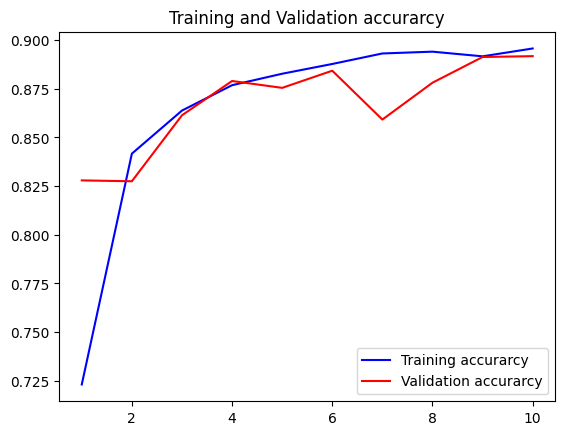

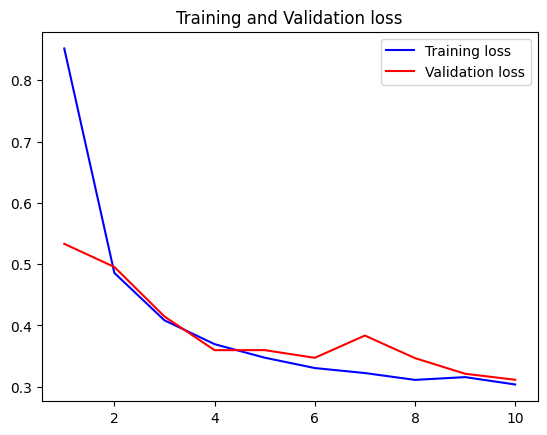

In [ ]:
acc = hist_mobilenet.history['accuracy']
val_acc = hist_mobilenet.history['val_accuracy']
loss = hist_mobilenet.history['loss']
val_loss = hist_mobilenet.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = model_mobilenet.evaluate(test_generator, verbose=1)
print('Test accuracy :', accuracy)
print('Test loss :', loss)

72/72 [==============================] - 7s 103ms/step - loss: 0.3450 - accuracy: 0.8841
Test accuracy : 0.8840958476066589
Test loss : 0.34500566124916077


## NASNet

In [ ]:
nasnet = tf.keras.applications.NASNetMobile(weights = 'imagenet',
                                                include_top = False,
                                                input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3) 
                                                )

nasnet.trainable = False

In [ ]:
inputs = tf.keras.Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3))

x = nasnet(inputs)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(len(categories), activation="softmax")(x)

model_nasnet = tf.keras.Model(inputs = inputs, 
                    outputs = x, 
                    name="TomatoLeafDisease_NASNetMobile")

model_nasnet.summary()

Model: "TomatoLeafDisease_NASNetMobile"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 NASNet (Functional)         (None, 8, 8, 1056)        4269716   
                                                                 
 global_average_pooling2d_5   (None, 1056)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 1056)              0         
                                                                 
 dense_5 (Dense)             (None, 10)                10570     
                                                                 
Total params: 4,280,286
Trainable params: 10,570
Non-trainable params: 4,269,716
_____________________

In [ ]:
opt = Adam(learning_rate= 0.001)

model_nasnet.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
hist_nasnet = model_nasnet.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10,
                    batch_size= BATCH_SIZE,
                    validation_steps= 71)

Epoch 1/10
574/574 [==============================] - 325s 538ms/step - loss: 1.1457 - accuracy: 0.6313 - val_loss: 0.8381 - val_accuracy: 0.7289
Epoch 2/10
574/574 [==============================] - 301s 525ms/step - loss: 0.7278 - accuracy: 0.7658 - val_loss: 0.6908 - val_accuracy: 0.7729
Epoch 3/10
574/574 [==============================] - 296s 515ms/step - loss: 0.6321 - accuracy: 0.7926 - val_loss: 0.6196 - val_accuracy: 0.7958
Epoch 4/10
574/574 [==============================] - 297s 517ms/step - loss: 0.5846 - accuracy: 0.8065 - val_loss: 0.5651 - val_accuracy: 0.8028
Epoch 5/10
574/574 [==============================] - 298s 519ms/step - loss: 0.5437 - accuracy: 0.8177 - val_loss: 0.5647 - val_accuracy: 0.8050
Epoch 6/10
574/574 [==============================] - 303s 528ms/step - loss: 0.5302 - accuracy: 0.8224 - val_loss: 0.5713 - val_accuracy: 0.8037
Epoch 7/10
574/574 [==============================] - 307s 535ms/step - loss: 0.5089 - accuracy: 0.8257 - val_loss: 0.5034 -

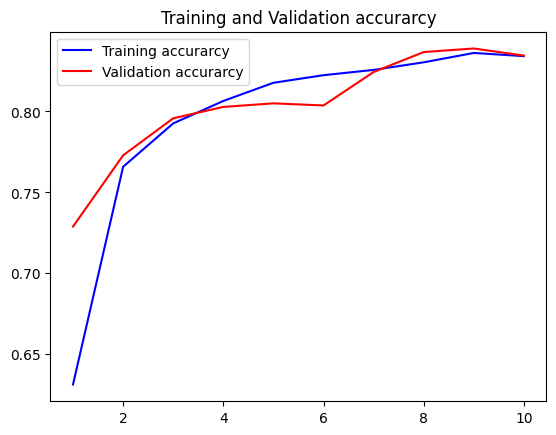

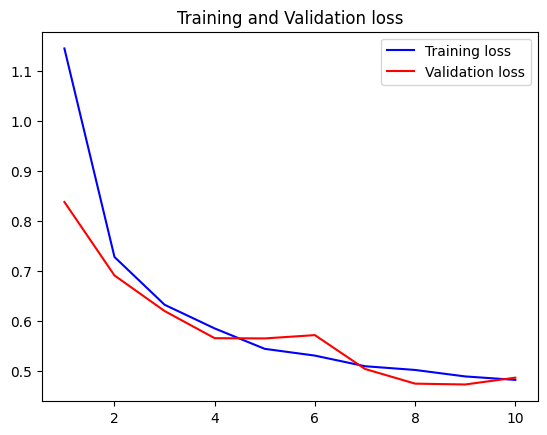

In [ ]:
acc = hist_nasnet.history['accuracy']
val_acc = hist_nasnet.history['val_accuracy']
loss = hist_nasnet.history['loss']
val_loss = hist_nasnet.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

## Inception 

In [ ]:
inception = tf.keras.applications.InceptionV3(weights = 'imagenet',
                                                include_top = False,
                                                input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3) 
                                                )

inception.trainable = False

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
inputs = tf.keras.Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3))

x = inception(inputs)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(len(categories), activation="softmax")(x)

model_inception = tf.keras.Model(inputs = inputs, 
                    outputs = x, 
                    name="TomatoLeafDisease_InceptionV3")

In [ ]:
opt = Adam(learning_rate= 0.001)

model_inception.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
hist_inception = model_inception.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10,
                    batch_size= BATCH_SIZE,
                    validation_steps= 71)

Epoch 1/10
574/574 [==============================] - 312s 531ms/step - loss: 1.0152 - accuracy: 0.6618 - val_loss: 0.7222 - val_accuracy: 0.7694
Epoch 2/10
574/574 [==============================] - 295s 514ms/step - loss: 0.6327 - accuracy: 0.7908 - val_loss: 0.5638 - val_accuracy: 0.8147
Epoch 3/10
574/574 [==============================] - 293s 510ms/step - loss: 0.5573 - accuracy: 0.8119 - val_loss: 0.5092 - val_accuracy: 0.8354
Epoch 4/10
574/574 [==============================] - 291s 506ms/step - loss: 0.5089 - accuracy: 0.8258 - val_loss: 0.5143 - val_accuracy: 0.8239
Epoch 5/10
574/574 [==============================] - 293s 511ms/step - loss: 0.4893 - accuracy: 0.8316 - val_loss: 0.4503 - val_accuracy: 0.8565
Epoch 6/10
574/574 [==============================] - 296s 516ms/step - loss: 0.4749 - accuracy: 0.8392 - val_loss: 0.4514 - val_accuracy: 0.8433
Epoch 7/10
574/574 [==============================] - 297s 517ms/step - loss: 0.4592 - accuracy: 0.8403 - val_loss: 0.4351 -

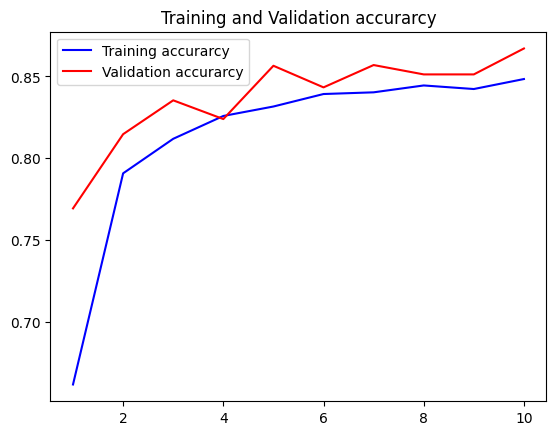

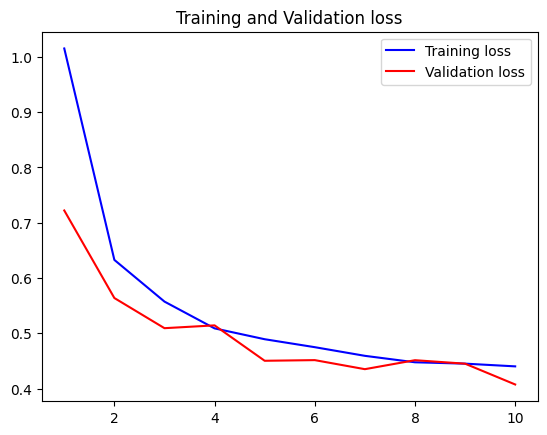

In [ ]:
acc = hist_inception.history['accuracy']
val_acc = hist_inception.history['val_accuracy']
loss = hist_inception.history['loss']
val_loss = hist_inception.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

## ResNet50

In [ ]:
resnet = tf.keras.applications.ResNet50V2(weights = 'imagenet',
                                                include_top = False,
                                                input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3) 
                                                )

resnet.trainable = False

94668760/94668760 [==============================] - 5s 0us/step


In [ ]:
inputs = tf.keras.Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3))

x = resnet(inputs)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(len(categories), activation="softmax")(x)

model_resnet = tf.keras.Model(inputs = inputs, 
                    outputs = x, 
                    name="TomatoLeafDisease_ResNet50")

In [ ]:
opt = Adam(learning_rate= 0.001)

model_resnet.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
hist_resnet = model_resnet.fit(train_generator,
                    validation_data=val_generator,
                    epochs=15,
                    batch_size= BATCH_SIZE,
                    validation_steps= 71)

Epoch 1/15
574/574 [==============================] - 306s 522ms/step - loss: 0.8189 - accuracy: 0.7354 - val_loss: 0.4505 - val_accuracy: 0.8666
Epoch 2/15
574/574 [==============================] - 299s 521ms/step - loss: 0.4537 - accuracy: 0.8554 - val_loss: 0.3655 - val_accuracy: 0.8869
Epoch 3/15
574/574 [==============================] - 299s 520ms/step - loss: 0.3876 - accuracy: 0.8750 - val_loss: 0.3098 - val_accuracy: 0.9067
Epoch 4/15
574/574 [==============================] - 295s 513ms/step - loss: 0.3520 - accuracy: 0.8836 - val_loss: 0.2961 - val_accuracy: 0.9124
Epoch 5/15
574/574 [==============================] - 295s 514ms/step - loss: 0.3240 - accuracy: 0.8934 - val_loss: 0.2795 - val_accuracy: 0.9080
Epoch 6/15
574/574 [==============================] - 296s 515ms/step - loss: 0.3099 - accuracy: 0.8965 - val_loss: 0.2719 - val_accuracy: 0.9137
Epoch 7/15
574/574 [==============================] - 296s 516ms/step - loss: 0.2969 - accuracy: 0.8999 - val_loss: 0.2659 -

# **Classification Report**

In [ ]:
def create_classification_report(nama_model):
    y_pred = nama_model.predict(test_generator)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes

    cm = confusion_matrix(y_true, y_pred)
    class_names = list(test_generator.class_indices.keys())

    plt.figure(figsize=(8, 6), dpi=100)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

    report = classification_report(y_true, y_pred, target_names=class_names)
    print(report)

## MobileNet

72/72 [==============================] - 8s 101ms/step


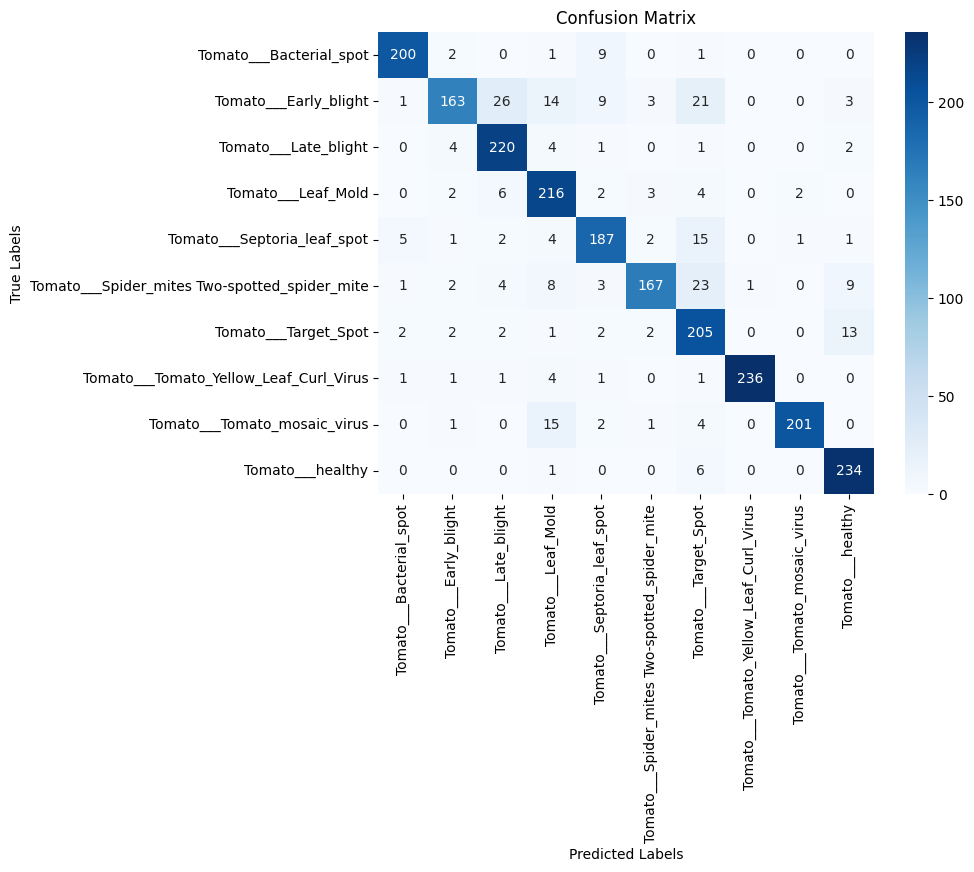

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.95      0.94      0.95       213
                        Tomato___Early_blight       0.92      0.68      0.78       240
                         Tomato___Late_blight       0.84      0.95      0.89       232
                           Tomato___Leaf_Mold       0.81      0.92      0.86       235
                  Tomato___Septoria_leaf_spot       0.87      0.86      0.86       218
Tomato___Spider_mites Two-spotted_spider_mite       0.94      0.77      0.84       218
                         Tomato___Target_Spot       0.73      0.90      0.80       229
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       1.00      0.96      0.98       245
                 Tomato___Tomato_mosaic_virus       0.99      0.90      0.94       224
                             Tomato___healthy       0.89      0.97      0.93       241

                                     accu

In [ ]:
create_classification_report(model_mobilenet)

## NASNet

72/72 [==============================] - 8s 111ms/step


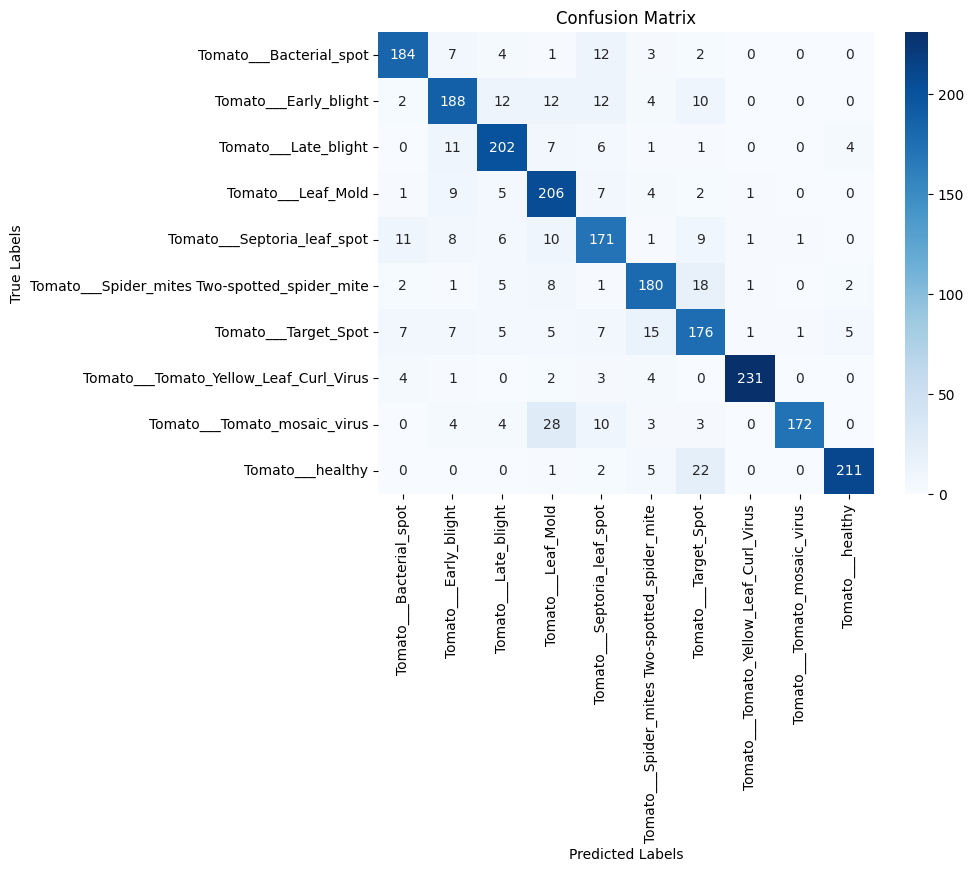

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.87      0.86      0.87       213
                        Tomato___Early_blight       0.80      0.78      0.79       240
                         Tomato___Late_blight       0.83      0.87      0.85       232
                           Tomato___Leaf_Mold       0.74      0.88      0.80       235
                  Tomato___Septoria_leaf_spot       0.74      0.78      0.76       218
Tomato___Spider_mites Two-spotted_spider_mite       0.82      0.83      0.82       218
                         Tomato___Target_Spot       0.72      0.77      0.75       229
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.98      0.94      0.96       245
                 Tomato___Tomato_mosaic_virus       0.99      0.77      0.86       224
                             Tomato___healthy       0.95      0.88      0.91       241

                                     accu

In [ ]:
create_classification_report(model_nasnet)

## Inception

72/72 [==============================] - 13s 134ms/step


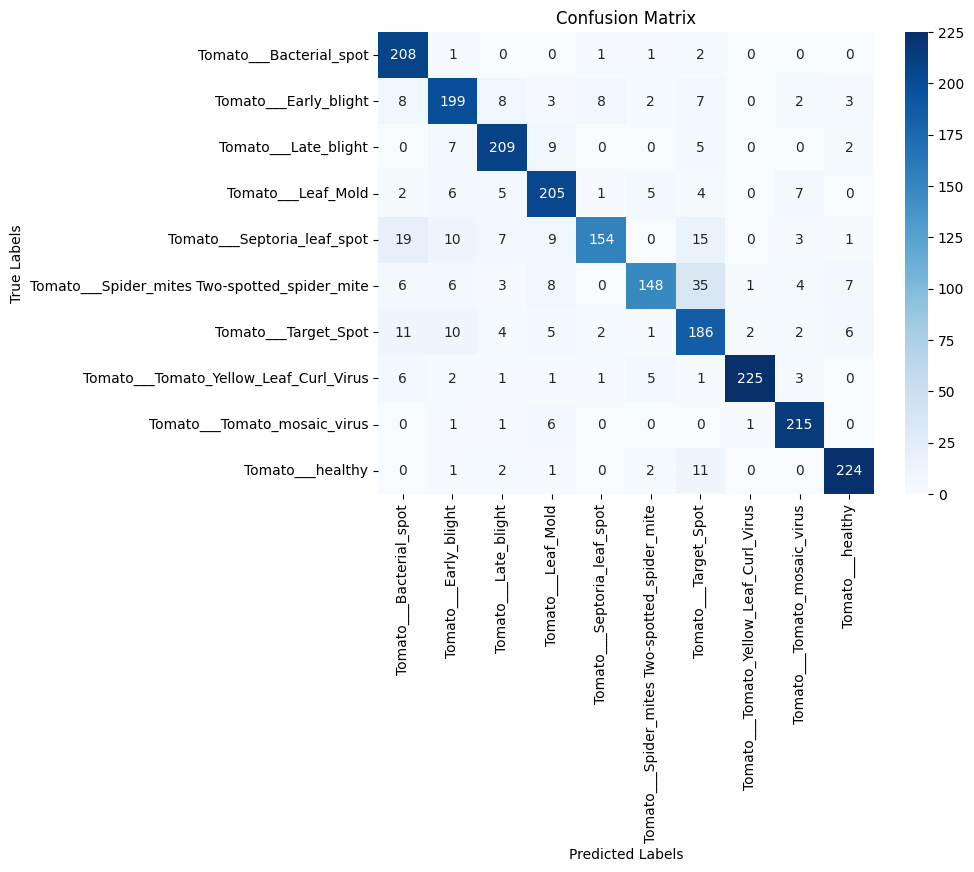

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.80      0.98      0.88       213
                        Tomato___Early_blight       0.82      0.83      0.82       240
                         Tomato___Late_blight       0.87      0.90      0.89       232
                           Tomato___Leaf_Mold       0.83      0.87      0.85       235
                  Tomato___Septoria_leaf_spot       0.92      0.71      0.80       218
Tomato___Spider_mites Two-spotted_spider_mite       0.90      0.68      0.77       218
                         Tomato___Target_Spot       0.70      0.81      0.75       229
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.98      0.92      0.95       245
                 Tomato___Tomato_mosaic_virus       0.91      0.96      0.93       224
                             Tomato___healthy       0.92      0.93      0.93       241

                                     accu

In [ ]:
create_classification_report(model_inception)

## ResNet50

72/72 [==============================] - 16s 181ms/step


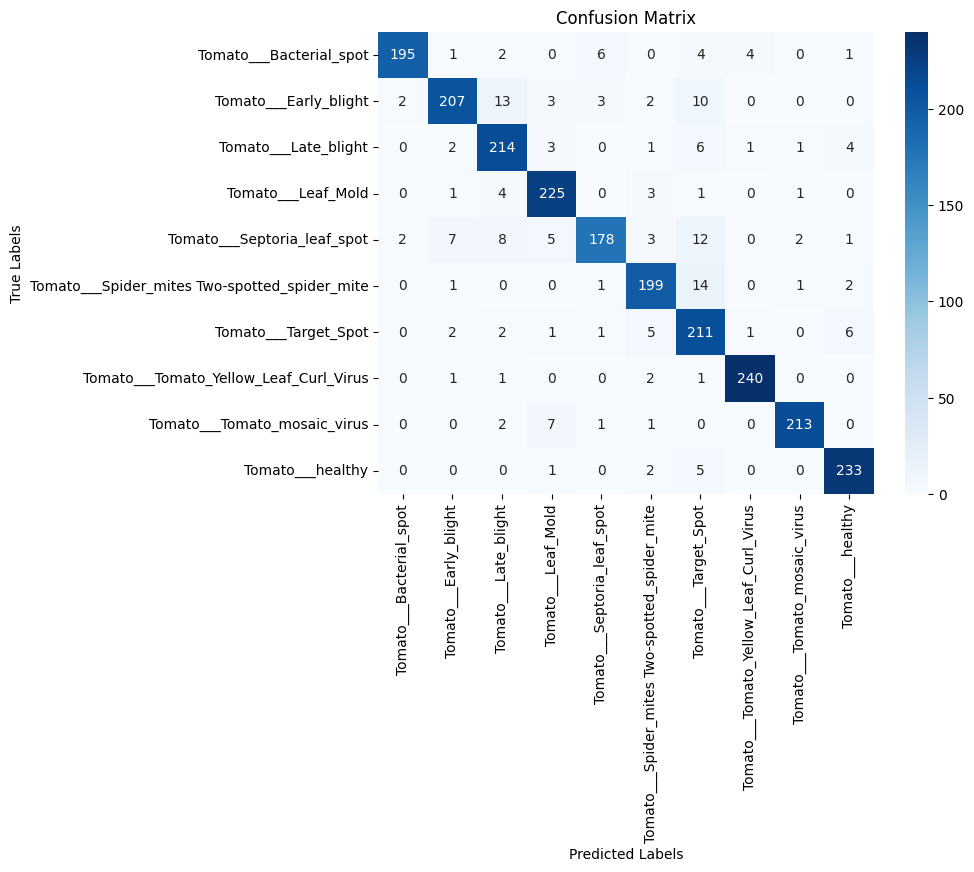

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.98      0.92      0.95       213
                        Tomato___Early_blight       0.93      0.86      0.90       240
                         Tomato___Late_blight       0.87      0.92      0.90       232
                           Tomato___Leaf_Mold       0.92      0.96      0.94       235
                  Tomato___Septoria_leaf_spot       0.94      0.82      0.87       218
Tomato___Spider_mites Two-spotted_spider_mite       0.91      0.91      0.91       218
                         Tomato___Target_Spot       0.80      0.92      0.86       229
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.98      0.98      0.98       245
                 Tomato___Tomato_mosaic_virus       0.98      0.95      0.96       224
                             Tomato___healthy       0.94      0.97      0.95       241

                                     accu

In [ ]:
create_classification_report(model_resnet)

# **Test Data baru**

In [ ]:
#@title
uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model_2.predict(images, batch_size=10)
  print(fn)
  print(classes)

In [ ]:
# Mengunggah gambar

uploaded = files.upload()

class_names = list(val_generator.class_indices.keys())

for fn in uploaded.keys():
  # Memuat gambar dan mengubah ukurannya
  path = fn
  image = np.array(Image.open(path).convert("RGB").resize((IMAGE_SIZE, IMAGE_SIZE)))
  image = image / 255
  img_array = tf.expand_dims(image, 0)

  # Prediksi gambar menggunakan model
  classes = model_resnet.predict(img_array)

  predicted_class_index = np.argmax(classes)
  predicted_class = class_names[predicted_class_index]
  confidence_level = classes[0][predicted_class_index] * 100

  print(fn)
  print("Gambar ini adalah", predicted_class)
  print("Confidence:", confidence_level, "%")

Saving 360_F_423006610_ZmVNWp8RYRi7ZqOyUKSc5AJnnFIFy7SN.jpg to 360_F_423006610_ZmVNWp8RYRi7ZqOyUKSc5AJnnFIFy7SN (1).jpg
1/1 [==============================] - 0s 23ms/step
360_F_423006610_ZmVNWp8RYRi7ZqOyUKSc5AJnnFIFy7SN.jpg
Gambar ini adalah Tomato___healthy
Confidence: 91.83000922203064 %


# Save Model

In [ ]:
model_resnet.save('/content/tomatoes.h5')

In [ ]:
#!zip -r /content/tomato_model.zip /content/tomato_model

  adding: content/tomato_model/ (stored 0%)
  adding: content/tomato_model/variables/ (stored 0%)
  adding: content/tomato_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/tomato_model/variables/variables.index (deflated 75%)
  adding: content/tomato_model/assets/ (stored 0%)
  adding: content/tomato_model/fingerprint.pb (stored 0%)
  adding: content/tomato_model/saved_model.pb (deflated 91%)
  adding: content/tomato_model/keras_metadata.pb (deflated 96%)


In [ ]:
files.download('/content/tomatoes.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>